### 📚 데이터 증식

- `transf`
    - Dataset을 정의하기 전에 정의
    - 많은 기능들이 이미지 타입이 PIL일 경우 작동하기 때문에 사용전에 데이터 타입을 확인해야 한다.
- 그외
    - 회전, 흑백 이미지 등

In [2]:
import torchvision.transforms as tr
import PIL

transf = tr.Compose([tr.ToPILImage(), 
                     tr.RandomCrop(60),
                     # 이미지 밝기, 대비, 색조를 변형
                     tr.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                     # 이미지 뒤집기
                     tr.RandomHorizontalFlip(), 
                     tr.ToTensor()])

--------------------------------------------------------------------------------------------------------

### 📚 조기 종료

#### 💡 라이브러리 불러오기

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

#### 💡 학습, 검증, 평가 데이터 생성하기

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)

trainset, valset = torch.utils.data.random_split(dataset, [30000, 20000])
trainloader =  torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

#### 💡 GPU 연산 확인

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


#### 💡 모델 정의하기

In [11]:
import torchsummary

In [64]:
class ResidualBlock(nn.Module) :
    
    def __init__(self, in_channels, out_channels, stride=1) :
        super(ResidualBlock, self).__init__()
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # 컨볼루션 연산 2개를 포함한 블록 만들기
            # Batch Normalization : 각 배치의 평균과 분산을 이용해서 데이터를 정규화하는 방법으로 학습을 빠르게 할 수 있다.
        self.conv_block = nn.Sequential(nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                                        nn.BatchNorm2d(self.out_channels),
                                        nn.ReLU(),
                                        nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                                        nn.BatchNorm2d(self.out_channels))
        
        # 위의 설명 참고 (사이즈가 달라지거나, 채널이 달라지면 ~ 조건문 실행)
        if self.stride != 1 or self.in_channels != self.out_channels :
            self.downsample = nn.Sequential(nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=stride, bias=False),
                                            nn.BatchNorm2d(self.out_channels))
            
    def forward(self, x) :
        out = self.conv_block(x)
        
        # 사이즈 조정이 필요하다면 입력값의 크기를 조정한다. 
        if self.stride != 1 or self.in_channels != self.out_channels :
            x = self.downsample(x)
            
        # Skip connection
        out = F.relu(x + out)
        return out
    
    

class ResNet(nn.Module) :
    def __init__(self, num_blocks, num_classes=10) :
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        # 입력 이미지가 들어와 연산을 수행하는 기본층
        self.base = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU())
        
        # 기본층을 제외한 4개의 블록이 필요하므로, self._make_layer를 이용하여 4개의 블록 묶음을 선언한다. 
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2)
        
        # 합성곱 층들을 지나면 최종적으로 크기가 4x4인 feature map 512개가 나온다. 
        # 크기가 4x4인 평균 풀링을 이용하면 각 피쳐맵 당 1개의 평균값이 나오기 때문에 성분이 512개인 벡터를 얻을 수 있다.
        self.gap = nn.AvgPool2d(4) # 4 is filter size
        
        # 클래스가 10개인 이미지를 분류하는 것이므로 최종적으로 512개의 노드에서 10개의 노드로 가는 FC를 정의한다. 
        self.fc = nn.Linear(512, num_classes)
        
        
    def _make_layer(self, out_channels, num_blocks, stride) :
        # 블록의 반복 횟수만큼 stride를 저장
        strides = [stride] + [1]*(num_blocks-1)
        
        # ResidualBlock을 불러와서 append를 이용해 차례로 붙여준다.
        # 이때 이전 출력 채널 크기와 다음 입력 채널 크기가 같아야 한다. 
        layers = []
        for stride in strides :
            block = ResidualBlock(self.in_channels, out_channels, stride)
            layers.append(block) 
            self.in_channels = out_channels
            
        # nn.Sequential에 넣어 모델을 구축한다.
        # *리스트 : 리스트의 길이에 상관 없이 모든 성분을 별도로 nn.Sequential에 전달하는 역할을 한다. 
        return nn.Sequential(*layers)
        
    
    # ResNet 클래스 안에 연산을 행하는 forward
    def forward(self, x) :
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [9]:
# 클래스를 불러오는 함수
# 각 모델마다 블록의 반복 횟수를 리스트로 정의하여 입력한다. 
# 이를 통해 18, 34 외에 4개의 블록을 가진 레이어의 개수를 조정할 수 있다. 
def modeltype(model) :
    if model == 'resnet18' :
        return ResNet([2, 2, 2, 2])
    elif model == 'resnet34' :
        return ResNet([3, 4, 6, 3])

In [10]:
resnet = modeltype('resnet18').to(device)

In [20]:
# 모델 출력
torchsummary.summary(resnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
     ResidualBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

#### 💡 손실 함수 및 최적화 기법

In [21]:
PATH = './cifar_resnet_early.pth'
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-3)

#### 💡 검증 데이터에 대한 손실 함수값을 연산하는 함수 정의하기

- 평가만 하기 때문에 **requires_grad**를 비활성화
- 평가 시 **정규화 기법**들이 작동하지 않도록 eval 모드로 설정
- 다시 모델을 train 모드로 변경한다.

In [23]:
def validation_loss(dataloader) :
    n = len(dataloader)
    running_loss = 0.0
    with torch.no_grad() :
        resnet.eval()
        for data in dataloader : 
            images, labels = data[0].to(device), data[1].to(device)
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
    resnet.train()
    return running_loss/n

#### 💡 학습하기

In [26]:
# 손실 함수 그래프를 그리기 위해
train_loss_list = []
val_loss_list = []

# 매 에폭마다 평균 손실함수값을 구하기 위해 n 설정
n = len(trainloader)

# 가장 낮은 검증 손실 함수값에 해당하는 모델을 저장하기 위해 손실 함수값 초기 기준을 1로 설정
early_stopping_loss = 1

In [27]:
for epoch in range(5) :
    running_loss = 0.0
    for data in trainloader :
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    train_loss = running_loss / n
    train_loss_list.append(train_loss)
    val_loss = validation_loss(valloader)
    val_loss_list.append(val_loss)
    print('[%d] train loss : %.3f, validation loss : %.3f' % (epoch+1, train_loss, val_loss))
    
    if val_loss < early_stopping_loss :
        torch.save(resnet.state_dict(), PATH)
        ealry_stopping_train_loss = train_loss
        early_stopping_val_loss = val_loss
        early_stopping_epoch = epoch
        
print('Fianl pretrained model >> [%d] train loss : %.3f, validation loss : %.3f' % (early_stopping_epoch+1, early_stopping_train_loss, early_stopping_val_loss))


KeyboardInterrupt: 

#### 💡 손실 함수값 그리기

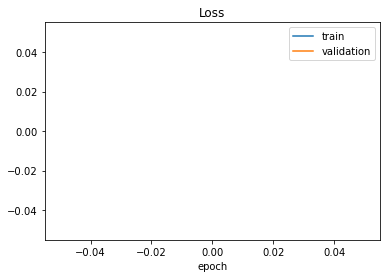

In [59]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.legend(['train', 'validation'])
plt.title("Loss")
plt.xlabel("epoch")
plt.show()

--------------------------------------------------------------------------------------------------------

### 📚 L2 정규화

In [60]:
optimizer = optim.Adam(resnet.parameters(), lr=1e-3, weight_decay=1e-3)

--------------------------------------------------------------------------------------------------------

### 📚 Dropout

In [66]:
class Regressor(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.fc1 = nn.Linear(13, 50)
        self.fc2 = nn.Linear(50, 1)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x) :
        x = self.dropout(F.relu(self.fc(x)))
        x = F.relu(self.fc2(x))
        return x

--------------------------------------------------------------------------------------------------------

### 📚 Batch 정규화

--------------------------------------------------------------------------------------------------------

### 📚 교란 라벨

#### 💡 교란라벨 정의하기

In [67]:
class DisturbLabel(torch.nn.Module) :
    def __init__(self, alpha, num_classes) :
        super(DisturbLabel, self).__init__()
        self.alpha = alpha
        self.C = num_classes
        # 실제 라벨을 뽑을 확률
        self.p_c = (1 - ((self.C-1)/self.C)*(alpha/100))
        # 나머지
        self.p_i = (1-self.p_c)/(self.C-1)
        
    def forward(self, y) :
        # 앞서 언급한 라벨이 뽑힐 확률 분포 (3/100, 3/100, 3/100, 3/100, 3/100, 73/100, 3/100, 3/100, 3/100, 3/100)을 만들어준다. 
        y_tensor = y.type(torch.LongTensor).view(-1, 1)
        depth = self.C
        y_one_hot = torch.ones(y_tensor.size()[0], depth) * self.p_i
        y_one_hot.scatter_(1, y_tensor, self.p_c)
        
        # 해당 확률을 이용해 Multinoulli 분포를 통해 샘플을 뽑는다.
        y_one_hot = y_one_hot.view(*(tuple(y.shape) + (-1,)))
        distribution = torch.distributions.OneHoetCategorical(y_one_hot)
        y_disturbed = distribution.sample()
        
        # 10개의 원소 중 가장 큰 값의 라벨을 뽑는다.
        y_disturbed = y_disturbed.max(dim=1)[1]
        return y_disturbed

#### 💡 교란라벨 선언 및 적용하기

In [68]:
disturblabels = DisturbLabel(alpha=30, num_classes=10)

In [ ]:
for epoch in range(50) :
    running_loss = 0.0
    for data in trainloader :
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        labels = disturblabels(labels).to(device)
        loss = criterion(outputs, labels)
        ...이하 생략...

--------------------------------------------------------------------------------------------------------

### 📚 교란값

#### 💡 노이즈 생성하기

In [ ]:
# target 값과 noise 비율을 받는다.
def noise_generator(x, alpha) :
    # 임의로 정한 정규분포에 따른 노이즈 생성
    noise = torch.normal(0, 1e-8, size=(len(x), 1))
    # 노이즈 타깃이 아닌 값은 노이즈를 0으로 한다. 
    noise[torch.randint(0, len(x), (int(len(x)*(1-alpha)),))] = 0
    return noise

#### 💡 교란값 선언 및 적용하기

In [ ]:
for epoch in range(400) :
    for data in trainloader :
        inputs, values = data
        optimizer.zero_grad()
        outputs = model(inputs)
        values = values + noise_generator(values, alpha)
        loss = criterion(outputs, values)
        ...이하 생략...

--------------------------------------------------------------------------------------------------------

### 📚 라벨 스무딩

#### 💡 라벨 스무딩 정의 및 선언하기

In [81]:
class LabelSmoothingLoss(nn.Module) : 
    def __init__(self, classes, smoothing=0.0, dim=-1) :
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim
        
    def forward(self, pred, target) :
        # cross-entropy 부분의 log softmax를 미리 계산한다. 
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad() : 
            # 예측값과 동일한 크기의 영텐서 만들기
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls-1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        # 위에서 만든 pred를 함께 사용해 cross entropy loss 함수를 계산
        return torch.mean(torch.sum(-true_dis * pred, dim=self.dim))

In [83]:
# nn.CrossEntropyLoss() 대신, LabelSmoothingLoss로 criterion 선언
criterion = LabelSmoothingLoss(classes=10, smoothing=0.2)